In [1]:
from ROOT import TFile,vector
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import asarray

from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import seaborn as sns

import os

from PlottingScripts import CV, Spline, Tune1, sampHist, distVar,distplot_wratio

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Welcome to JupyROOT 6.18/04


## Load  Things Up

In [5]:
#old tagger
#DIRT_POT = 3.2571504301e+20
#NUMU_POT = 1.219190611900899e+21
#NUE_POT = 1.31390317541e+23
#DATA_POT = 4.4e19    #3.456e+19
#EXT_POT = (12315978.0) / float (7704849.0) * DATA_POT# 14542235.0 / 10640228.0 * DATA_POT

#wc tagger
NUMU_POT = 4.71579e+20
NUE_POT  = 9.80259e+22
DIRT_POT = 2.61947e+20
DATA_POT = 4.403e+19   #  run1
#DATA_POT = 8.808e+18 # run3 (no beam quality cut)
EXT_POT = (22474918.0) / float ( 9776965.0) * DATA_POT #run1
#EXT_POT = (22474918.0) / float ( 2264083.0) * DATA_POT

POT_SCALE_FACTOR = DATA_POT
NUMU_SCALE = POT_SCALE_FACTOR / float(NUMU_POT)
NUE_SCALE = POT_SCALE_FACTOR / float(NUE_POT)
EXT_SCALE = POT_SCALE_FACTOR / float(EXT_POT)
DATA_SCALE = POT_SCALE_FACTOR / float(DATA_POT)
DIRT_SCALE = POT_SCALE_FACTOR / float(DIRT_POT)

In [6]:
mctag = 'Feb21-final'# 'Mar30-WC'#'Feb21-final'# 
datatag = 'Mar4-WC'

emptycut = 'Enu_1m1p > 0'
orthogonalitycut = 'MaxShrFrac < .2'
precuts = 'OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'

thiscut = orthogonalitycut + ' and ' + precuts

df_data_presel = pd.read_parquet('../data/pickles/data_goodruns_precuts_%s.parquet'%datatag).query(thiscut)
df_numu_presel = pd.read_parquet('../data/pickles/numu_goodruns_precuts_%s.parquet'%mctag).query(thiscut)
df_nue_presel = pd.read_parquet('../data/pickles/nue_goodruns_precuts_%s.parquet'%mctag).query(thiscut)
df_ext_presel = pd.read_parquet('../data/pickles/ext_goodruns_precuts_%s.parquet'%datatag).query(thiscut)
df_dirt_presel = pd.read_parquet('../data/pickles/dirt_goodruns_precuts_%s.parquet'%mctag).query(thiscut)

## This is where the magic happens

In [7]:
simpleHists = []
simpleHists.append(sampHist(df_numu_presel,'numu','crimson',1,NUMU_SCALE))
simpleHists.append(sampHist(df_nue_presel,r'$\nu_e$ Intrinsic Overlay','pink',1,NUE_SCALE))
simpleHists.append(sampHist(df_dirt_presel,'Dirt','peru',1,DIRT_SCALE))
simpleHists.append(sampHist(df_ext_presel,'ExtBNB','fuchsia',0,EXT_SCALE))

sampleHists = []
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_CCQE']"),r'$\nu_\mu$ CCQE','blue',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_MEC']"),r'$\nu_\mu$ MEC','cyan',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_piplusminus']"),r'$\nu_\mu$ Res $\pi^{+/-}$','darkgreen',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_pizero']"),r'$\nu_\mu$ Res $\pi^{0}$','greenyellow',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_other','nue_other','nue_MEC','nue_piplusminus','nue_pizero']"),r'BNB Other','gold',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['badreco']"),r'BNB Bad Reco','coral',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['nLmP']"),r'BNB Not 1L1P','crimson',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['offvtx']"),r'BNB 1L1P Off Vertex','grey',1,NUMU_SCALE))
sampleHists.append(sampHist(df_nue_presel,r'$\nu_e$ Intrinsic Overlay','pink',1,NUE_SCALE))
sampleHists.append(sampHist(df_dirt_presel,'Dirt','peru',1,DIRT_SCALE))
sampleHists.append(sampHist(df_ext_presel,'ExtBNB','fuchsia',0,EXT_SCALE))

run1Hist = sampHist(df_data_presel,'bnb5e19','',0,DATA_SCALE)

In [8]:
nbins = 45
s_annotation = 'All Precuts, Orthogonality Cuts'

df_signal = df_numu_presel.query("mc_label in ['numu_CCQE'] and abs((MC_energyInit-Enu_1m1p)/MC_energyInit) < .2 and MC_nproton==1 and MC_nlepton==1")    
#df_extbkg = pd.concat([df_ext_presel,df_dirt_presel,df_numu_presel.query("mc_label in ['nue_offvtx','numu_offvtx'] or abs((MC_energyInit-Enu_1m1p)/MC_energyInit) > .2 or not (MC_nproton==1 and MC_nlepton==1)")],sort=False)
df_extbkg = pd.concat([df_ext_presel,df_dirt_presel,df_numu_presel.query("mc_label in ['nue_offvtx','numu_offvtx']")],sort=False)
df_nubkg = df_numu_presel.query("mc_label not in ['numu_CCQE','numu_offvtx','nue_offvtx'] or abs((MC_energyInit-Enu_1m1p)/MC_energyInit) > .2 or not (MC_nproton==1 and MC_nlepton==1)")

#df_signal = df_numu_presel.query("mc_label in ['numu_CCQE']")
#df_extbkg = pd.concat([df_ext_presel,df_dirt_presel,df_numu_presel.query("mc_label in ['offvtx','nLmP','badreco']")],sort=False)
#df_nubkg = df_numu_presel.query("mc_label not in ['numu_CCQE'])

Events: 4287.0
MC:  6133.23708967567
Max Bin ct (data): 295.0
Min Bin ct (data): 7.0


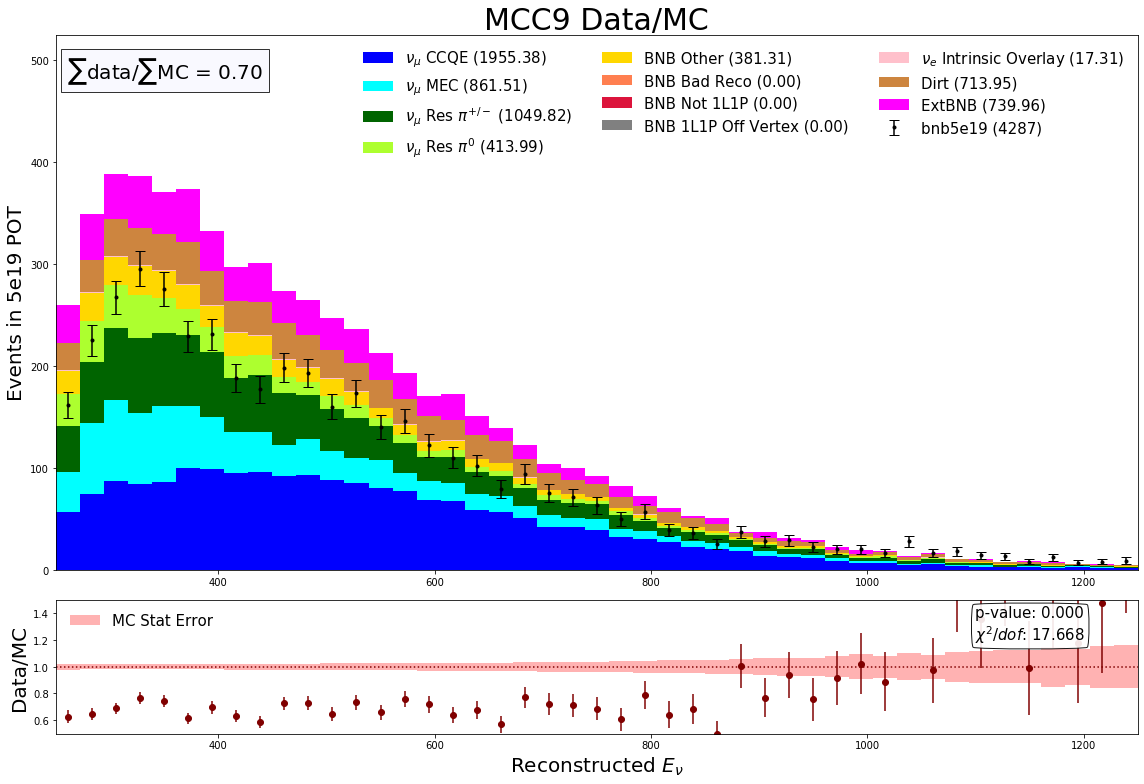

In [9]:
vartest = 'Enu_1m1p'
varname = r'Reconstructed $E_\nu$'
myrange = (250,1250)

fig,ax = plt.subplots(figsize=(16,11))
distplot_wratio(vartest,nbins,myrange,sampleHists,run1Hist,varname)

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


Events: 4506.0
MC:  6369.623414158867
Max Bin ct (data): 584.0
Min Bin ct (data): 0.0
Events: 4367.0
MC:  6192.752111157955
Max Bin ct (data): 134.0
Min Bin ct (data): 19.0


KeyboardInterrupt: 

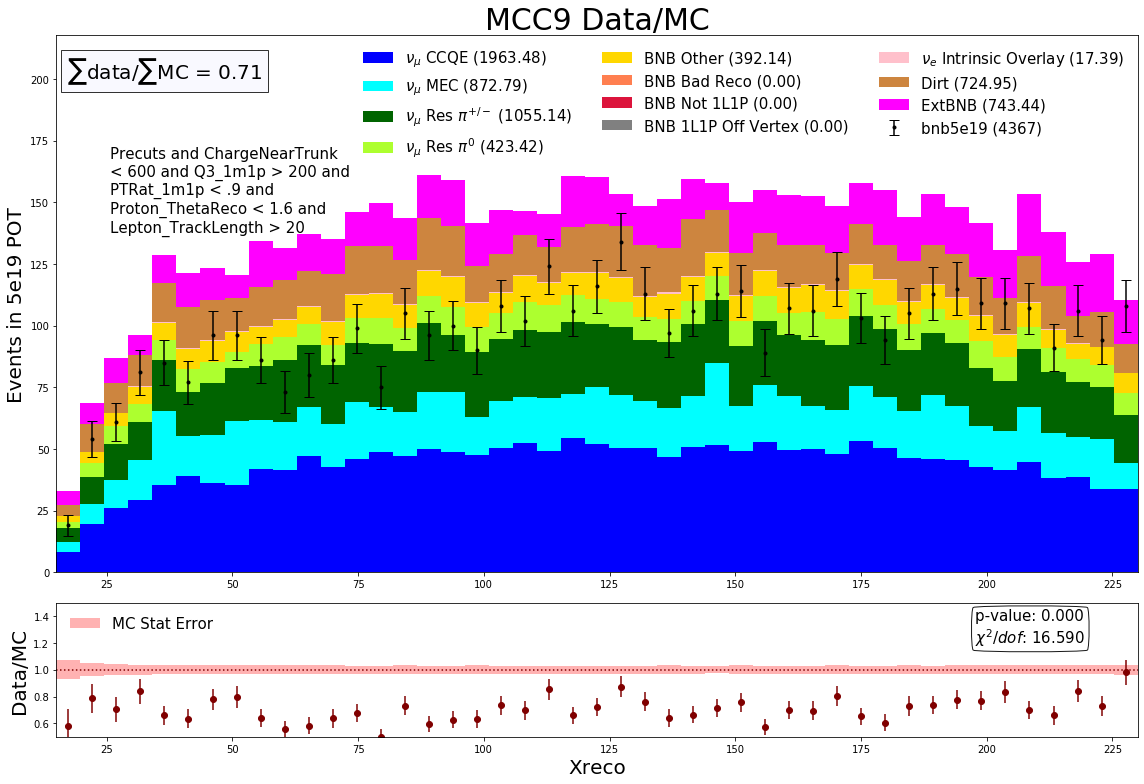

In [10]:
#BIG DUMPUS

plt.ioff()

bigvarlist = ['run', 'Xreco', 'Yreco', 'Zreco', 'FailedBoost', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'ChargeNearTrunk', 'LongTrackLen',
 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p',
 'Q0_1m1p', 'Q3_1m1p', 'Lepton_PhiReco', 'Lepton_ThetaReco', 'Lepton_TrackLength', 'Muon_Edep', 'Lepton_EdgeDist', 'Proton_PhiReco', 'Proton_ThetaReco',
 'Proton_TrackLength', 'Proton_Edep', 'Proton_EdgeDist', 'TotPE','MaxPEFrac']
bigrangelist = [(4900,8000),(15,230),(-100,100),(0,1020),(0,1),(0,1),(0,.7),(.5,np.pi),(.5,4),(.5,5),(0,600),(5,600),
 (5,150),(0,.2),(0,.2),(0,5),(250,1250),(0,np.pi),(0,np.pi),(0,800),(0,.9),(0,2),(.1,.8),(0,6e5),(0,4000),(-2000,500),
 (70,600),(200,1000),(-np.pi,np.pi),(0,np.pi),(5,200),(20,600),(15,100),(-np.pi,np.pi),(0,1.6),
 (5,150),(50,400),(15,100),(0,4000),(.05,.5)]

dumphole = 'run1_presel_mar31'

s_ano_simple_w = wrap('Precuts and '+boxcuts,28)
s_ano_simple = '' 
for ln in s_ano_simple_w:
    s_ano_simple += ln + '\n'


if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for i in range(len(bigvarlist)):
    fig,ax = plt.subplots(figsize=(16,11))
    ax0 = distplot_wratio(bigvarlist[i],nbins,bigrangelist[i],sampleHists,run1Hist,bigvarlist[i])
    ax0.annotate(s_ano_simple,xy=(.05,.6), xycoords='axes fraction',fontsize=15)
    plt.savefig(dumphole+'/'+bigvarlist[i]+'.png')
    plt.close(fig)

Events: 1330.0
MC:  1204.494764788932
Max Bin ct (data): 292.0
Min Bin ct (data): 23.0


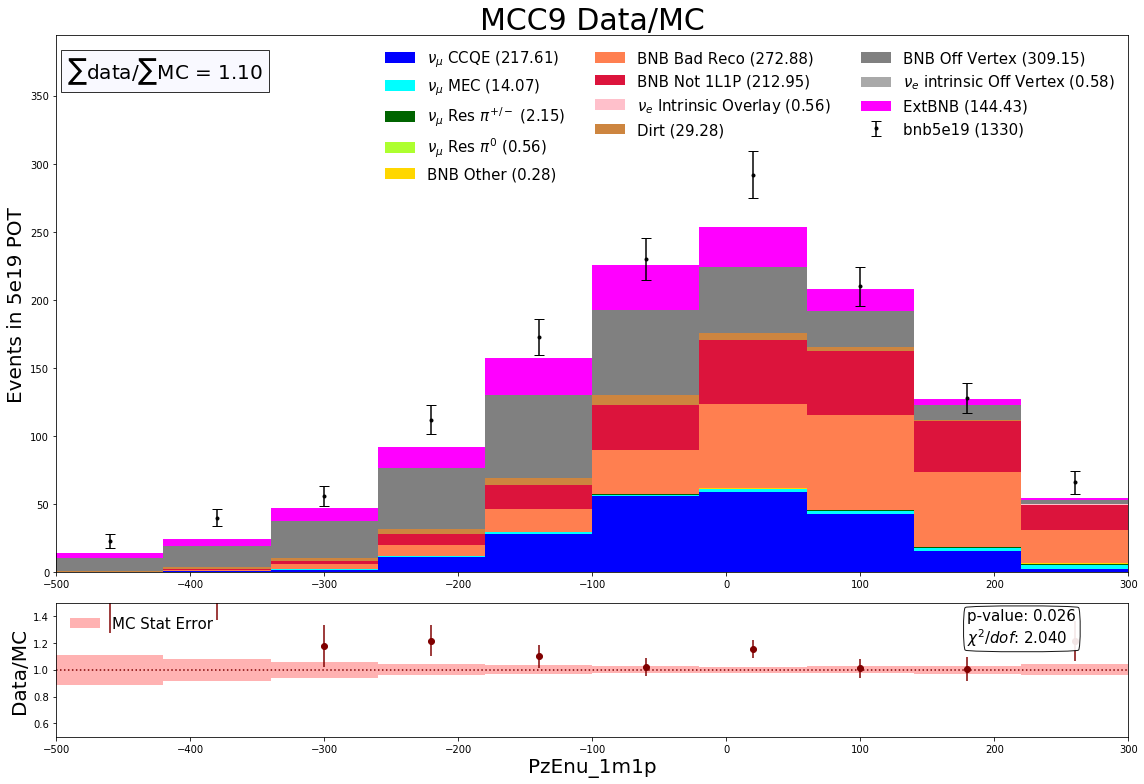

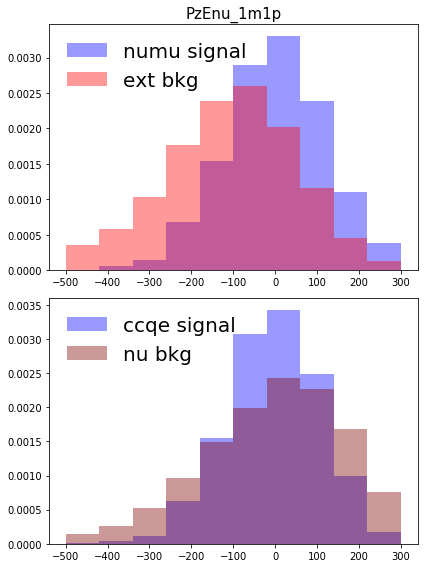

In [64]:
vartest = 'PzEnu_1m1p'
varname = vartest
myrange = (-500,300)

fig,ax = plt.subplots(figsize=(16,11))
distplot_wratio(vartest,nbins,myrange,sampleHists,run1Hist,varname)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(df_signal[vartest].values,nbins,range=myrange,color='blue',alpha=.4,label='numu signal',density=1)
_ = ax[0].hist(df_extbkg[vartest].values,nbins,range=myrange,color='red',alpha=.4,label='ext bkg',density=1)
ax[0].legend(frameon=False,fontsize=20)

_ = ax[1].hist(df_nusignal[vartest].values,nbins,range=myrange,color='blue',alpha=.4,label='ccqe signal',density=1)
_ = ax[1].hist(df_nubkg[vartest].values,nbins,range=myrange,color='maroon',alpha=.4,label='nu bkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

Events: 1448.0
MC:  1297.4760915436243
Max Bin ct (data): 584.0
Min Bin ct (data): 0.0


NameError: name 'var_mec' is not defined

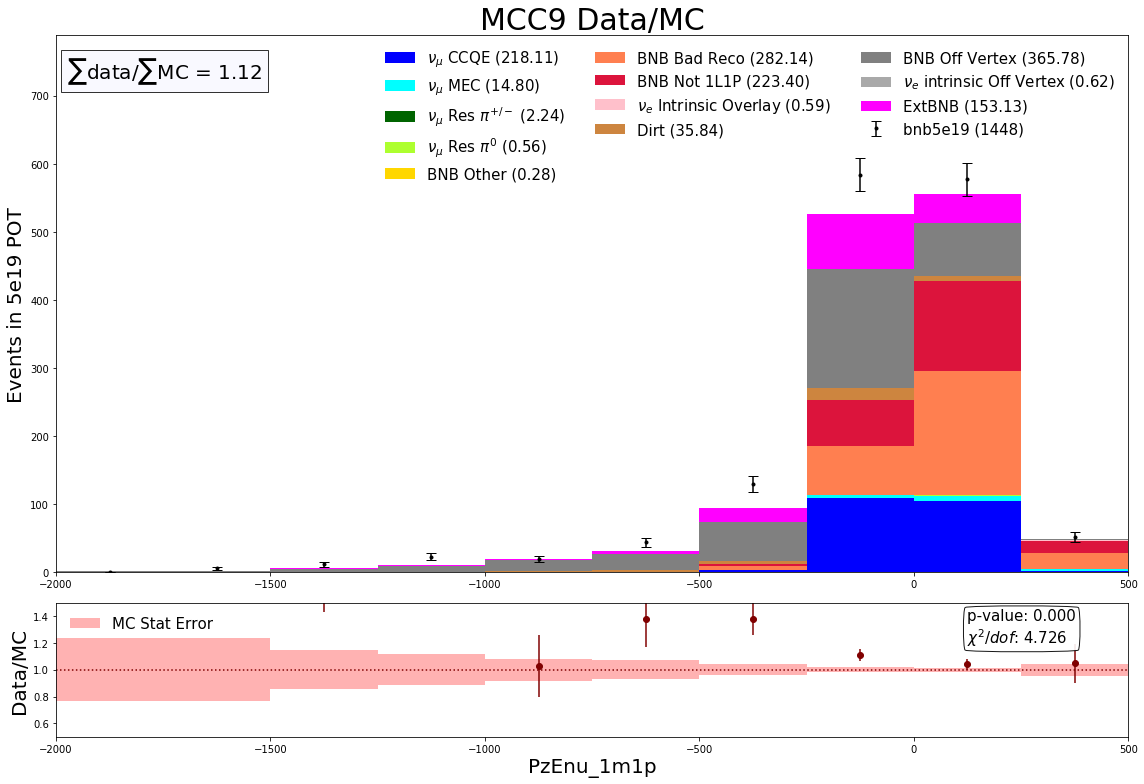

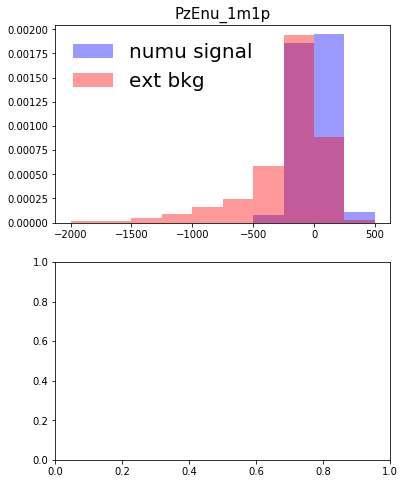

In [65]:
vartest = 'PzEnu_1m1p'
varname = vartest
myrange = (-2000,500)

fig,ax = plt.subplots(figsize=(16,11))
distplot_wratio(vartest,nbins,myrange,sampleHists,run1Hist,varname)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(6,8))
ax[0].set_title(varname,fontsize=15)
_ = ax[0].hist(df_signal[vartest].values,nbins,range=myrange,color='blue',alpha=.4,label='numu signal',density=1)
_ = ax[0].hist(df_extbkg[vartest].values,nbins,range=myrange,color='red',alpha=.4,label='ext bkg',density=1)
ax[0].legend(frameon=False,fontsize=20)

var_nubkg = var_mec.tolist() + var_pizero.tolist() + var_piplusminus.tolist() + var_other.tolist()
_ = ax[1].hist(df_nusignal[vartest].values,nbins,range=myrange,color='blue',alpha=.4,label='ccqe signal',density=1)
_ = ax[1].hist(df_nubkg[vartest].values,nbins,range=myrange,color='maroon',alpha=.4,label='nu bkg',density=1)
ax[1].legend(frameon=False,fontsize=20)
fig.tight_layout()

# Weight the bdts

In [11]:
# Cosmic vs numu
jarretvars = ['SphB_1m1p','PzEnu_1m1p','BjXB_1m1p','BjYB_1m1p','Proton_ThetaRecoB_1m1p','Muon_ThetaRecoB_1m1p','Eta','OpenAngB_1m1p','PT_1m1p']
vars_vd = ['BjXB_1m1p','BjYB_1m1p','PT_1m1p','SphB_1m1p','Proton_ThetaRecoB_1m1p','Muon_ThetaRecoB_1m1p','Eta','Q0_1m1p','Q3_1m1p','ChargeNearTrunk','Phis','LongTrackLen','PTRat_1m1p','PzEnu_1m1p']
vars_vd2 = ['Enu_1m1p','Eta','ChargeNearTrunk','OpenAngB_1m1p','PTB_1m1p','AlphaTB_1m1p','BjXB_1m1p','BjYB_1m1p','SphB_1m1p','PzEnu_1m1p','Q0_1m1p','Q3_1m1p','ThetasB_1m1p','PhisB_1m1p','PTRat_1m1p','LongTrackLen','Proton_PhiRecoB_1m1p','Proton_ThetaRecoB_1m1p']
vars_vd4 = ['Eta','ChargeNearTrunk','OpenAng','PT_1m1p','AlphaT_1m1p','BjX_1m1p','BjY_1m1p','Sph_1m1p','PzEnu_1m1p','Q0_1m1p','Q3_1m1p','Thetas','Phis','PTRat_1m1p','LongTrackLen']# ,'TotPE','MaxPEFrac']
vars_cos_vd0 = ['ChargeNearTrunk','OpenAng','PzEnu_1m1p','Thetas','Sph_1m1p','Lepton_PhiReco','Proton_PhiReco','LongTrackLen']

testo = ['Eta','ChargeNearTrunk','AlphaT_1m1p','BjX_1m1p','BjY_1m1p','Sph_1m1p','Q0_1m1p','Q3_1m1p','PTRat_1m1p','LongTrackLen']
stronk = ['OpenAng','Thetas','PzEnu_1m1p']

vars_cos_mar5 = ['Eta','ChargeNearTrunk','OpenAng','PT_1m1p','PhiT_1m1p','BjX_1m1p','BjY_1m1p','Sph_1m1p','PzEnu_1m1p','Q0_1m1p','Q3_1m1p','Thetas','Phis','PTRat_1m1p','LongTrackLen']

vars_cos_mar6 = ['Eta','ChargeNearTrunk','OpenAng','PT_1m1p','PhiT_1m1p','BjX_1m1p','BjY_1m1p','Sph_1m1p','PzEnu_1m1p','Q0_1m1p','Q3_1m1p','Lepton_ThetaReco','Lepton_PhiReco','PTRat_1m1p','Lepton_TrackLength']

vars_cos_allofem = ['Eta','ChargeNearTrunk','PT_1m1p','PhiT_1m1p','AlphaT_1m1p','Sph_1m1p','Q0_1m1p','Q2_1m1p','Q3_1m1p','Lepton_ThetaReco','Lepton_PhiReco','Proton_ThetaReco','Proton_PhiReco','PTRat_1m1p','Lepton_TrackLength','Thetas','Phis','Proton_TrackLength','OpenAng','PzEnu_1m1p']
vars_cos_byagreement = ['Q0_1m1p','Phis','AlphaT_1m1p','PhiT_1m1p','Sph_1m1p','PTRat_1m1p','ChargeNearTrunk','Proton_ThetaReco','Proton_PhiReco','Eta','Q2_1m1p',]

myvars = vars_cos_allofem

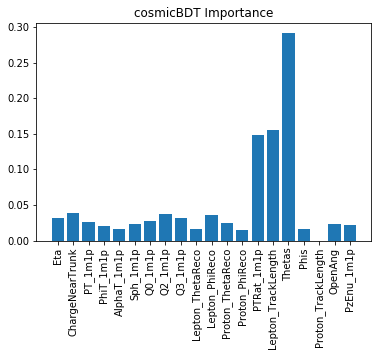

Accuracy Test:   0.9826655392220632
Accuracy Train:  0.9876505352363961
TestAcc - TrainAcc =  -0.49849960143328875


In [12]:
X = df_signal[myvars].values.tolist()
Y_cos = df_extbkg[myvars].values.tolist()

#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_cos))]

seed = 15
test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_cos), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
cosmicBDT = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      #colsample_bytree = .8,
                      objective='binary:logistic',
                      subsample = 0.8, 
                      n_estimators=1000, 
                      max_depth=5, 
                      gamma=5)
cosmicBDT.fit(x_train, y_train)

y_checkV = cosmicBDT.predict(x_test) #
y_checkT = cosmicBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('cosmicBDT Importance')
plt.bar(range(len(cosmicBDT.feature_importances_)), cosmicBDT.feature_importances_)
plt.xticks(range(len(cosmicBDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

acc_test = accuracy_score(y_test, predictionsV)
acc_train = accuracy_score(y_train,predictionsT)
accuracy_diff = (acc_test-acc_train)*100. #
print("Accuracy Test:  ",acc_test)
print("Accuracy Train: ",acc_train)
print("TestAcc - TrainAcc = ",accuracy_diff)

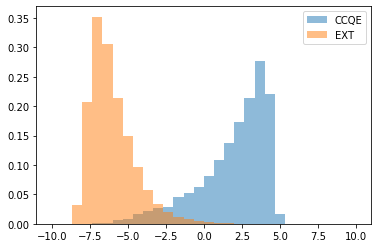

In [14]:
fig,ax = plt.subplots(figsize=(6,4))
bdt_score_ccqe = cosmicBDT.predict(X ,output_margin=True)
bdt_score_ext = cosmicBDT.predict(Y_cos,output_margin=True)

_ = plt.hist(bdt_score_ccqe,30,(-10,10),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_ext,30,(-10,10),alpha = .5,density=1,label='EXT')

plt.legend()

In [95]:
pickle.dump(cosmicBDT,open( "../1mu1pSelection/cosmicbdt_1mu1p_mar31_ccqe.pickle", "wb" ),protocol=2)

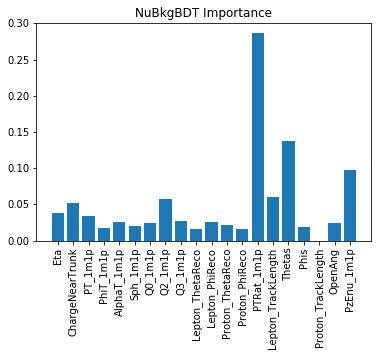

Accuracy Test:   0.9681156712059985
Accuracy Train:  0.9745044122553701
TestAcc - TrainAcc =  -0.6388741049371593


In [15]:
X = df_signal[myvars].values.tolist()
Y_nubkg = df_nubkg[myvars].values.tolist()

#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_nubkg))]

seed = 15
test_size = 0.33
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_nubkg), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
nubkgBDT = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      #colsample_bytree = .8,
                      objective='binary:logistic',
                      subsample = 0.8, 
                      n_estimators=1000, 
                      max_depth=5, 
                      gamma=5)
nubkgBDT.fit(x_train, y_train)

y_checkV = nubkgBDT.predict(x_test) #
y_checkT = nubkgBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('NuBkgBDT Importance')
plt.bar(range(len(nubkgBDT.feature_importances_)), nubkgBDT.feature_importances_)
plt.xticks(range(len(nubkgBDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

acc_test = accuracy_score(y_test, predictionsV)
acc_train = accuracy_score(y_train,predictionsT)
accuracy_diff = (acc_test-acc_train)*100. #
print("Accuracy Test:  ",acc_test)
print("Accuracy Train: ",acc_train)
print("TestAcc - TrainAcc = ",accuracy_diff)


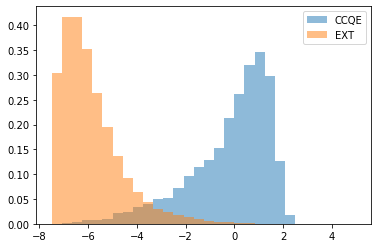

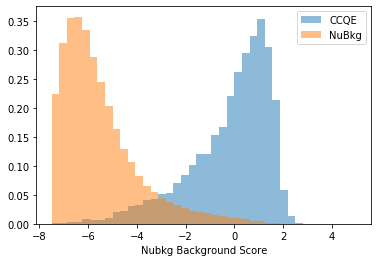

In [16]:
fig,ax = plt.subplots(figsize=(6,4))
bdt_score_ccqe = nubkgBDT.predict(X ,output_margin=True)
bdt_score_ext = nubkgBDT.predict(Y_cos,output_margin=True)

_ = plt.hist(bdt_score_ccqe,30,(-7.5,5),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_ext,30,(-7.5,5),alpha = .5,density=1,label='EXT')

plt.legend()

fig,ax = plt.subplots(figsize=(6,4))
bdt_score_nubkg = nubkgBDT.predict(Y_nubkg,output_margin=True)

_ = plt.hist(bdt_score_ccqe,40,(-7.5,5),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_nubkg,40,(-7.5,5),alpha = .5,density=1,label='NuBkg')
ax.set_xlabel('Nubkg Background Score')

plt.legend()

In [17]:
bdts = [cosmicBDT,nubkgBDT]
pickle.dump(bdts,open( "../1mu1pSelection/bdtweights_1mu1p_WC_apr1.pickle", "wb" ),protocol=2)

In [ ]:
# march25 - energy reco
# march 26 - true 1L1P

## experimental zone

In [ ]:
#thiscut  = 'Thetas < 3 and abs(sin(Lepton_PhiReco)) < .8'
fancycut = 'PTRat_1m1p < -(Thetas - 1.5)/3 + 1 and Thetas < 3'
emptycut = 'OpenAng >= 0 and Thetas > 2'
thiscut = emptycut

var1 = 'LongTrackLen'
var2 = 'Phis'
ext_var1 = df_ext_presel.query(thiscut)[var1].values
ext_var2 = df_ext_presel.query(thiscut)[var2].values

numu_var1 = df_numu_presel.query('scedr_corrected <  5 and '+thiscut)[var1].values
numu_var2 = df_numu_presel.query('scedr_corrected <  5 and '+thiscut)[var2].values

fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
plt.scatter(ext_var1,ext_var2,color='mistyrose',alpha=.9)
plt.scatter(numu_var1,numu_var2,color='lavender',alpha=1)
sns.kdeplot(numu_var1,numu_var2,label='ccqe',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)
sns.kdeplot(ext_var1,ext_var2,label='ext',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)

ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)
plt.legend(fontsize=20,loc='lower right')
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0,2*np.pi)
#plt.ylim(0,np.pi)

#x0 = np.linspace(0,6)
#y0 = -(x0-2.5)*(.6)+2
#plt.plot(x0,y0)

In [ ]:
cut1  = 'Thetas < 3 and abs(sin(Lepton_PhiReco)) < .95'
fancycut1 = 'PTRat_1m1p < -(Thetas - 1.5)/3 + 1 and Thetas < 3'
fancycut2 = 'PzEnu_1m1p > (OpenAng - 2.5)*(3000.0/1.25)'
fancycut3 = 'OpenAng < -(Thetas - 2.5)*(.6)+2'
thiscut = fancycut3

print((len(df_MEC_numu_presel.query(thiscut))+len(df_pizero_numu_presel.query(thiscut))+len(df_piplusminus_numu_presel.query(thiscut))+len(df_other_numu_presel.query(thiscut)))/float((len(df_MEC_numu_presel)+len(df_pizero_numu_presel)+len(df_piplusminus_numu_presel)+len(df_other_numu_presel))))
print(len(df_CCQE_numu_presel.query(thiscut))/float(len(df_CCQE_numu_presel)))